In [1]:
import os
import cv2
import numpy as np
from glob import glob
from scipy.io import loadmat
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K
from keras.utils import io_utils
from tensorflow.python.platform import tf_logging as logging
from google.colab import drive

drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/collage/segmentation')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
DATA_DIR = "/content/drive/MyDrive/Colab Notebooks/collage/segmentation/data/rawdata/humanparsing"
train_num = 30
val_num = 10

all_images = sorted(glob(os.path.join(DATA_DIR, "val/Images/*")))
all_masks = sorted(glob(os.path.join(DATA_DIR, "val/Human/*")))

train_images, train_masks = all_images[:train_num], all_masks[:train_num]
val_images, val_masks = all_images[train_num:train_num+val_num], all_masks[train_num:train_num+val_num]

In [3]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
IMAGE_SIZE = 512
BATCH_SIZE = 8
NUM_CLASSES = 1
import tensorflow_addons as tfa

def read_image(image_path, mask=False):
  image = tf.io.read_file(image_path)
  image = tf.image.decode_png(image, channels=3)
  image.set_shape([None, None, 3])
  image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
  if not mask:
      image = image / 255
  return image

def load_data(image_list, mask_list):
  image = read_image(image_list)
  mask = read_image(mask_list, mask=True)
  return image, mask

def random_crop(input_image, real_image, size):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, size, size, 3])
  img,msk = cropped_image[0], cropped_image[1]
  return img,msk

def augment(input_image, input_mask):

  if tf.random.uniform(()) > 0.3:
      ratio = tf.random.uniform(shape=[],minval=400, maxval=440, dtype=tf.int32)
      input_image, input_mask = random_crop(input_image, input_mask, ratio)
      input_image = tf.image.resize(input_image, (IMAGE_SIZE, IMAGE_SIZE))
      input_mask = tf.image.resize(input_mask, (IMAGE_SIZE, IMAGE_SIZE))

  input_image = tf.image.random_brightness(input_image, 0.2)

  saturation_factor = tf.random.uniform((),0,2)
  input_image = tf.image.adjust_saturation(input_image, saturation_factor)

  if tf.random.uniform(()) > 0.5:
      input_image = tf.image.flip_left_right(input_image)
      input_mask = tf.image.flip_left_right(input_mask)

  rot_factor = tf.cast(tf.random.uniform(shape=[],minval=-6, maxval=6, dtype=tf.int32), tf.float32)
  angle = np.pi/(12*6) *rot_factor
  input_image = tfa.image.rotate(input_image, angle)
  input_mask = tfa.image.rotate(input_mask, angle)

  return input_image, input_mask

def cast_mask(input_image, input_mask):
  
  input_mask = tf.math.reduce_sum(input_mask, axis=2)
  input_mask = input_mask[..., tf.newaxis]
  input_mask = tf.cast(input_mask>0, dtype=tf.float32)
  return input_image,input_mask

def data_generator(image_list, mask_list, augument=True):
  dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
  dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
  if augument:
    dataset = dataset.map(augment)
  dataset = dataset.map(cast_mask)

  dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
  return dataset

train_dataset = data_generator(train_images, train_masks)
print("Train Dataset:", train_dataset)

val_dataset = data_generator(val_images, val_masks, augument=False)
print("Validation Dataset:", val_dataset)

Train Dataset: <BatchDataset element_spec=(TensorSpec(shape=(8, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(8, 512, 512, 1), dtype=tf.float32, name=None))>
Validation Dataset: <BatchDataset element_spec=(TensorSpec(shape=(8, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(8, 512, 512, 1), dtype=tf.float32, name=None))>


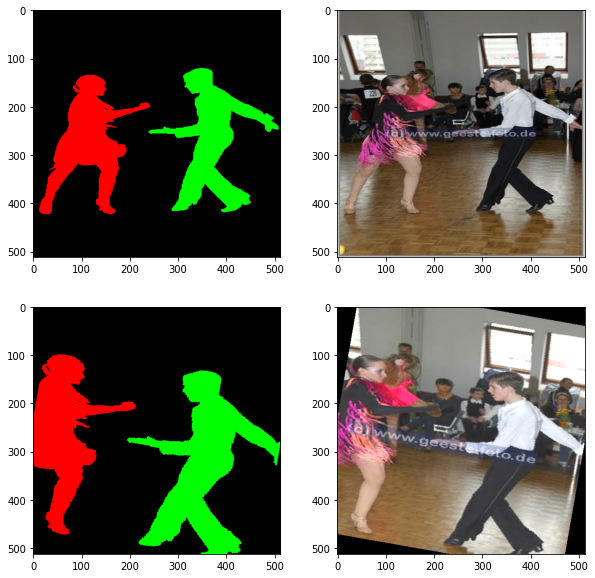

In [5]:
_, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

idx = 9
img = read_image(train_images[idx])
msk = read_image(train_masks[idx], mask=True)

augmented_img, augmented_msk = augment(img,msk)


# axes[0][0].imshow(np.squeeze(np.where(np.sum(msk, axis=2)>0, 1,0)))
axes[0][0].imshow(np.squeeze(msk))
axes[0][1].imshow(img)
axes[1][0].imshow(np.squeeze(augmented_msk))
axes[1][1].imshow(augmented_img)
plt.show()

In [6]:
def conv_block_2times(x, num_filters):
  for _ in range(2):
    x = layers.Conv2D(num_filters, 3, strides=1, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
  return x

def encoder_block(x, num_filters):
  x = conv_block_2times(x, num_filters)
  p = layers.MaxPooling2D((2,2))(x)
  return x, p 

def decoder_block(x, skip, num_filters):
  x = layers.Conv2DTranspose(num_filters, (2,2), strides=2, padding='same')(x)
  x = layers.Concatenate(axis=-1)([x, skip])
  x = conv_block_2times(x, num_filters)
  return x

In [7]:
def Unet(image_size, num_classes):
    inputs = keras.Input(shape=(image_size, image_size, 3))

    x1, p1 = encoder_block(inputs, 64)
    x2, p2 = encoder_block(p1, 128)
    x3, p3 = encoder_block(p2, 256)
    x4, p4 = encoder_block(p3, 512)

    center = conv_block_2times(p4,1024)

    d1 = decoder_block(center, x4, 512)
    d2 = decoder_block(d1, x3, 256)
    d3 = decoder_block(d2, x2, 128)
    d4 = decoder_block(d3, x1, 64)   

    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same", activation='sigmoid')(d4)
    # Define the model
    return keras.Model(inputs, model_output)

In [8]:
class unfreeze_layers_reduce_lr(tf.keras.callbacks.ReduceLROnPlateau):

  def __init__(self,
               monitor='val_loss',
               factor=0.1,
               patience=10,
               verbose=0,
               mode='auto',
               min_delta=1e-4,
               cooldown=0,
               min_lr=0,
               freezed=False,
               **kwargs):
      super().__init__(monitor, factor, patience, verbose, mode, min_delta, cooldown, min_lr)
      self.freezed = False


  def on_epoch_end(self, epoch, logs=None):
    logs = logs or {}
    logs['lr'] = K.get_value(self.model.optimizer.lr)
    current = logs.get(self.monitor)
    if current is None:
      logging.warning('Learning rate reduction is conditioned on metric `%s` '
                      'which is not available. Available metrics are: %s',
                      self.monitor, ','.join(list(logs.keys())))
    else:
      if self.in_cooldown():
        self.cooldown_counter -= 1
        self.wait = 0

      if self.monitor_op(current, self.best):
        self.best = current
        self.wait = 0

      elif not self.in_cooldown():
        self.wait += 1
        if self.wait >= self.patience:
          
          if not self.freezed:
            for layer in self.model.layers:
                      layer.trainable = True
            self.freezed=True
            old_lr = K.get_value(self.model.optimizer.lr)
            new_lr = old_lr * 0.1
            K.set_value(self.model.optimizer.lr, new_lr)
            io_utils.print_msg(
                    f'\nEpoch {epoch +1}: '
                    f'Unfreezing backbone layers and reducing learning rate to {new_lr}')
            self.cooldown_counter = self.cooldown
            self.wait = 0

          else:
            old_lr = K.get_value(self.model.optimizer.lr)
            if old_lr > np.float32(self.min_lr):
              new_lr = old_lr * self.factor
              new_lr = max(new_lr, self.min_lr)
              K.set_value(self.model.optimizer.lr, new_lr)
              if self.verbose > 0:
                io_utils.print_msg(
                    f'\nEpoch {epoch +1}: '
                    f'ReduceLROnPlateau reducing learning rate to {new_lr}.')
              self.cooldown_counter = self.cooldown
              self.wait = 0

class CustomSaver(keras.callbacks.Callback):
  def __init__(self, save_path, save_name, frequency):
    self.save_path = save_path
    self.save_name = save_name
    self.frequency = frequency

  def on_epoch_end(self, epoch, logs={}):
      if (epoch+1) % self.frequency == 0 :
          name = self.save_path + self.save_name + f'{epoch+1:03d}.h5'
          self.model.save(name)
          io_utils.print_msg(
                    f'\nEpoch {epoch + 1}:'
                    f'saving model to {name}')

model_path, model_name = './model_weight/callback_test/', 'test_weight_epoch_'
model_path_best = './model_weight/callback_test/test_weight_best.h5'
csv_name = './model_weight/callback_test/test_weight.csv'

custom_saver = CustomSaver(model_path, model_name ,frequency=10)
reduce_lr = unfreeze_layers_reduce_lr(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', min_delta=1e-4, cooldown=0, min_lr=0,)
save_best = tf.keras.callbacks.ModelCheckpoint(model_path_best, monitor='val_loss', verbose=0, save_best_only=True)
write_log = tf.keras.callbacks.CSVLogger(csv_name, separator=',', append=True)

cb_list = [custom_saver, reduce_lr, save_best, write_log]

In [9]:
model = Unet(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)
loss = keras.losses.BinaryCrossentropy()
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    loss=loss,
    metrics=["accuracy",tf.keras.metrics.BinaryIoU()],
  )
# model.summary()

In [10]:
history = model.fit(train_dataset, validation_data=val_dataset,
                    callbacks=cb_list,
                    epochs=100)

Epoch 1/100
3/3 [==============================] - 27s 3s/step - loss: 1.0335 - accuracy: 0.5205 - binary_io_u: 0.3452 - val_loss: 115748683776.0000 - val_accuracy: 0.5294 - val_binary_io_u: 0.2647 - lr: 0.0100
Epoch 2/100
3/3 [==============================] - 3s 1s/step - loss: 0.8671 - accuracy: 0.4776 - binary_io_u: 0.2944 - val_loss: 2487431725056.0000 - val_accuracy: 0.5294 - val_binary_io_u: 0.2647 - lr: 0.0100
Epoch 3/100
3/3 [==============================] - ETA: 0s - loss: 0.6929 - accuracy: 0.5579 - binary_io_u: 0.2962
Epoch 3: Unfreezing backbone layers and reducing learning rate to 0.0009999999776482583
3/3 [==============================] - 3s 1s/step - loss: 0.6929 - accuracy: 0.5579 - binary_io_u: 0.2962 - val_loss: 248735776768.0000 - val_accuracy: 0.4706 - val_binary_io_u: 0.2353 - lr: 0.0100
Epoch 4/100
3/3 [==============================] - 4s 2s/step - loss: 0.6882 - accuracy: 0.5650 - binary_io_u: 0.2958 - val_loss: 1513604352.0000 - val_accuracy: 0.4706 - val_bi

KeyboardInterrupt: ignored

In [ ]:
model.summary()